Changes to previous version:

- added attribute mol to QiskitNaturePySCFSolver
- put definition of h2_mol outside of get_molecular_integrals
- integrated get_molecular_integrals as function inside of QiskitNaturePySCFSolver
- added calc_gradient function from our other code
- removed rep_energy from calc_gradient. It is already included in the ops, right??
- added and implemented nuc_grad_method attribute to QiskitNaturePySCFSolver, as well as as_scanner attribute and grad function


TODO: add simulator and dR attribute to QiskitNaturePySCFSolver, change dR to self.dR, change everything to atomic units (and then remove conversion factor for force), find out how to stop PySCF from printing loads of useless stuff, tidy up code, find out what the error message about complex numbers means, implement grad.converged attribute 

In [1]:
import numpy as np

from pyscf import ao2mo,gto, scf

from typing import Tuple

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit import BasicAer, Aer
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import CircuitStateFn, StateFn, PauliExpectation, CircuitSampler
from qiskit.utils import QuantumInstance




class QiskitNaturePySCFSolver:
    def __init__(self, 
                 mol):
        
        self.mol = mol
        self.qubit_op  = None
        self.converter = None
        self.norb = None
        self.nelec = None
        self.dR = 0.02 #step in unit of Angstrom
        
        

    def get_molecular_integrals(self, shifted = False, shifted_mol = None):

        # in the case that no shifted mol is given, compute integrals for self.mol
        if shifted == False:   
            molecule = self.mol
        else:
            molecule = shifted_mol

        mf = scf.RHF(molecule).run()
 
        # computing the 1e and 2e AO (atomic orbitals) integrals 
        h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
        h2 = molecule.intor("int2e")
        # comment : add aom (axis of symmetry) ???

        # transformations from AO to MO (molecular orbitals)
        h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
        h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

        #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

        nuclear_repulsion_energy=molecule.energy_nuc()

        ##########################################
        num_particles = mol_h2.nelec # correct ???
        ##########################################
        num_orb = h1.shape[0]        # correct ???
        ##########################################
        #print(f'Number of particles : {num_particles}')
        #print(f'Number of spin orbitals : {num_orb}')

        return h1_MO, h2_MO, num_orb, num_particles, nuclear_repulsion_energy

    
    def kernel(self, 
               h1_MO: np.array,
               h2_MO: np.array, 
               norb: int,
               nelec: Tuple[int, int],
               #coords: Sequence[tuple[float, float, float]],
               ecore: float = 0.0,
               **kwargs
    ) -> Operator:
        
        self.norb = norb
        self.nelec = nelec

        # Define an ElectronicEnergy instance containing the 1e and 2e integrals
        electronic_energy = ElectronicEnergy.from_raw_integrals(
                h1_MO, ao2mo.restore(1, h2_MO, self.norb)
            )
        electronic_energy.nuclear_repulsion_energy = ecore

        # Define an ElectronicStructureProblem
        problem = ElectronicStructureProblem(electronic_energy)

        second_q_ops = problem.second_q_ops()     # get second quantized operators
        problem.num_spatial_orbitals = self.norb  # define number of orbitals
        problem.num_particles = self.nelec        # define number of particles 
        
        problem.basis = ElectronicBasis.MO # 1e and 2e integrals are expected to be given in the Molecular Orbitals basis
        # TODO raise error if h1 and h2 not in MO basis ? how to check ? add argument to pass the basis ?
        
        """ 
        problem.molecule=MoleculeInfo(symbols=('H','H'), coords=((0.0, 0.0, 0.0),(1.0, 0.0, 0.0)) )
        print(problem.molecule)
        FC_transformer=FreezeCoreTransformer(freeze_core=True)
        problem = FC_transformer.transform(problem)
        """
        # TODO we need to give info about the molecule to use FreezeCoreTransformer 
        # question : how to do it in a smart way ? at the initialization ??
        
        hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
        hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=self.norb)) # add Nuclear Repulsion Energy
        #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
        
        mapper = ParityMapper()  # Set Mapper
        
        # Do two qubit reduction
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        qubit_op = converter.convert(hamiltonian, self.nelec)
        #print("q_op :\n", qubit_op) # print for checking purposes
        
        self.qubit_op  = qubit_op
        self.converter = converter
    
        return qubit_op
    

    def calc_ground_state(self) -> Tuple[QuantumCircuit, complex] :
        
        # question : vqe_ground is of type QuantumCircuit right? Answer: Yes, but we need it as CircuitStateFn
        # TODO raise error if kernel has not been called previously
        
        backend = BasicAer.get_backend("statevector_simulator")
        optimizer = SLSQP(maxiter=5)
        
        init_state = HartreeFock(num_spatial_orbitals=self.norb, 
                                 num_particles=self.nelec, 
                                 qubit_converter=self.converter
                                )
        
        var_form = UCCSD(qubit_converter=self.converter,
                         num_particles=self.nelec,
                         num_spatial_orbitals=self.norb, 
                         initial_state=init_state
                         )

        vqe = VQE(var_form, optimizer, quantum_instance=backend) 
        vqe_result = vqe.compute_minimum_eigenvalue(self.qubit_op)
        min_eng = vqe_result.eigenvalue
        final_params = vqe_result.optimal_parameters 

        vqe_ground = vqe.ansatz.bind_parameters(final_params)  
        
        return CircuitStateFn(vqe_ground), min_eng
    
    def calc_shifted_mols(self,index):
        ''' Calculates the shifted molecular geometries for force calculations.
        Input:
        - index: variable deciding which coordinate to shift
        Output:
        - shifted_mol_plus,shifted_mol_minus: copies of self.mol whose coordinates have been shifted by self.dR at 
        coordinate 'index'.
        '''
        shifted_plus = []
        shifted_minus = []
        
        atomic_config_list = self.mol._atom
       
        for (i,(spec,coord)) in enumerate(atomic_config_list):
            coord_ang = tuple([0.529177249*j for j in coord]) 
            shifted_plus.append([spec,coord_ang])
            shifted_minus.append([spec,coord_ang])
        
        #shifted_minus = shifted_plus.copy() ## for some reason even if I do this they are not copies
        
        num_atom = index//3 #which atom needs to be shifted
        pos = index%3 #which coordinate needs to be shifted
        
        
        #can't change tuple, so need to convert it to list, shift, and then convert back to tuple
        shifted_pos_plus = list(shifted_plus[num_atom][1])
        shifted_pos_minus = list(shifted_minus[num_atom][1])
        shifted_pos_plus[pos] += self.dR
        shifted_pos_minus[pos] -= self.dR
           
        shifted_plus[num_atom][1]= tuple(shifted_pos_plus)
        shifted_minus[num_atom][1]= tuple(shifted_pos_minus)

        
        shifted_mol_plus = gto.M(atom=shifted_plus,basis = self.mol.basis,charge = self.mol.charge,
                                 spin = self.mol.spin,symmetry = self.mol.symmetry)
        shifted_mol_minus = gto.M(atom=shifted_minus,basis = self.mol.basis,charge = self.mol.charge,
                                 spin = self.mol.spin,symmetry = self.mol.symmetry)
        
        return shifted_mol_plus, shifted_mol_minus
   
    
    def calc_gradient(self, psi, simulator='qasm'):
        
        num_coords = 3*self.mol.natm
    
        psi_0 = psi
        
        Ha = 4.36e-18 # 1 Hartree in SI units
        angst = 1.0e-10 # 1 Angstrom in unit of meters
        
        if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=1028)
        elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
        else:
            print('Error: simulator should be qasm or exact!')

        gradient = []

        #loop over particles
        for i in range(num_coords):

            #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
            shifted_mol_plus,shifted_mol_minus = self.calc_shifted_mols(i)
            qubit_op_plus = self.kernel(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_plus))

            #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
            qubit_op_minus = self.kernel(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_minus))

            #define desired observable (H_+ - H_-)/(2dR) = -force
            Obs = (qubit_op_plus-qubit_op_minus)

            #get the expectation value <psi_0|O|psi_0>¨

            measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0) 
            expectation = PauliExpectation().convert(measurable_expression)  
            sampler = CircuitSampler(q_instance).convert(expectation) 
            g = sampler.eval().real 

            gradient.append(g*Ha*(1/(2*self.dR*angst))*(1/8.2387234983)*1e8)
            # in the dimension of nN to avoid small values.
        grad_np = np.array(gradient) 
        grad_right_shape = np.reshape(grad_np,(self.mol.natm,3))
        grad_list = list(grad_right_shape)
        return grad_list
     
    def nuc_grad_method(self): 
        #needs to be something with attribute as_scanner, so we just return self
        return self
    
    def as_scanner(self):  
        
        '''as_scanner() needs to be something that has attridutes mol, converged and if you give it an argument, 
        it returns e_tot, gradient_of_potential'''
        
        def grad(mol):
            # Function that computes energy and energy gradient given molecular geometry
            self.mol = mol
            qubit_op = self.kernel(*self.get_molecular_integrals()) 
            psi_0, e_tot = self.calc_ground_state()
            gradient = self.calc_gradient(psi_0) 
            return e_tot, gradient
        
        grad.mol = self.mol
        grad.converged = True # Cheating here, but we can fix this later
        return grad

    
    



BOMD Time 0.00
converged SCF energy = -1.06610864931794
converged SCF energy = -1.0716472626551
converged SCF energy = -1.06042298524027
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06042298524027
converged SCF energy = -1.0716472626551
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
[['H', (0.0, 0.0, 0.0)], ['H', (1.0, 0.0, 0.0)]]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000000000
1 H     1.8897261246     0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07253205142794
converged SCF energy = -1.06135608294745
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06135608294745
converged SCF energy = -1.07253205142794
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06696297815546
converged SCF energy = -1.06696297815546
[('H', [0.00300390221067705, 1.440294615191762e-18, -2.1604419227876432e-17]), ('H', [1.8865889070353101, -1.5483167113311438e-17, 1.2242504229129975e-17])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0030039022     0.0000000000    -0.0000000000
1 H     1.8865889070    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y             

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07516206487808
converged SCF energy = -1.06413716129302
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06413716129302
converged SCF energy = -1.07516206487808
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06967338461489
converged SCF energy = -1.06967338461489
[('H', [0.012282217135584455, 2.7365597688643472e-17, -5.473119537728696e-17]), ('H', [1.8774237906924414, 7.201473075958807e-18, 4.89700169165199e-17])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0122822171     0.0000000000    -0.0000000000
1 H     1.8774237907     0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07942652582423
converged SCF energy = -1.06867279707426
converged SCF energy = -1.07408212151785
converged SCF energy = -1.07408212151785
converged SCF energy = -1.07408212151785
converged SCF energy = -1.07408212151785
converged SCF energy = -1.06867279707426
converged SCF energy = -1.07942652582423
converged SCF energy = -1.07408212151785
converged SCF energy = -1.07408212151785
converged SCF energy = -1.07408212151785
converged SCF energy = -1.07408212151785
[('H', [0.02760870370962752, 8.353708768112217e-17, -9.217885537227278e-17]), ('H', [1.862175151126572, 4.140847018676315e-17, 7.849605652795101e-17])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0276087037     0.0000000000    -0.0000000000
1 H     1.8621751511     0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08514876546829
converged SCF energy = -1.07481968854434
converged SCF energy = -1.08003027691935
converged SCF energy = -1.08003027691935
converged SCF energy = -1.08003027691935
converged SCF energy = -1.08003027691935
converged SCF energy = -1.07481968854434
converged SCF energy = -1.08514876546829
converged SCF energy = -1.08003027691935
converged SCF energy = -1.08003027691935
converged SCF energy = -1.08003027691935
converged SCF energy = -1.08003027691935
[('H', [0.04901611574192474, 7.41751726823757e-17, -1.2242504229129978e-16]), ('H', [1.8409863390817247, 1.5123093459513488e-17, 1.1522356921534094e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0490161157     0.0000000000    -0.0000000000
1 H     1.8409863391     0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09195827388172
converged SCF energy = -1.0822532804432
converged SCF energy = -1.08717191948482
converged SCF energy = -1.08717191948482
converged SCF energy = -1.08717191948482
converged SCF energy = -1.08717191948482
converged SCF energy = -1.0822532804432
converged SCF energy = -1.09195827388172
converged SCF energy = -1.08717191948482
converged SCF energy = -1.08717191948482
converged SCF energy = -1.08717191948482
converged SCF energy = -1.08717191948482
[('H', [0.07584680844555257, 1.0370121229380683e-16, -1.93719625743292e-16]), ('H', [1.8140317866106568, -1.0802209613938333e-18, 1.7499579574579906e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0758468084     0.0000000000    -0.0000000000
1 H     1.8140317866    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09935416553586
converged SCF energy = -1.09054281516544
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09054281516544
converged SCF energy = -1.09935416553586
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09504385970511
converged SCF energy = -1.09504385970511
[('H', [0.10825164058223424, 1.7643609036099081e-16, -2.952603961143112e-16]), ('H', [1.782364044024189, -8.209679306593044e-17, 2.0164124612684664e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1082516406     0.0000000000    -0.0000000000
1 H     1.7823640440    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10668151522745
converged SCF energy = -1.09914382023896
converged SCF energy = -1.10305074821501
converged SCF energy = -1.10305074821501
converged SCF energy = -1.10305074821501
converged SCF energy = -1.10305074821501
converged SCF energy = -1.09914382023896
converged SCF energy = -1.10668151522745
converged SCF energy = -1.10305074821501
converged SCF energy = -1.10305074821501
converged SCF energy = -1.10305074821501
converged SCF energy = -1.10305074821501
[('H', [0.14562472903018975, 2.2324566535472306e-16, -3.8815939879417985e-16]), ('H', [1.7460814679443584, -1.4150894594259062e-16, 2.3188743304587363e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1456247290     0.0000000000    -0.0000000000
1 H     1.7460814679    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y            

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11293246069503
converged SCF energy = -1.10718757854722
converged SCF energy = -1.11026009475572
converged SCF energy = -1.11026009475572
converged SCF energy = -1.11026009475572
converged SCF energy = -1.11026009475572
converged SCF energy = -1.10718757854722
converged SCF energy = -1.11293246069503
converged SCF energy = -1.11026009475572
converged SCF energy = -1.11026009475572
converged SCF energy = -1.11026009475572
converged SCF energy = -1.11026009475572
[('H', [0.18679139449972762, 3.0318201649786587e-16, -4.472114780170422e-16]), ('H', [1.7059624007835212, -1.8795844728252491e-16, 2.9165965957633175e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1867913945     0.0000000000    -0.0000000000
1 H     1.7059624008    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y             

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11685730285857
converged SCF energy = -1.11360554967411
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11360554967411
converged SCF energy = -1.11685730285857
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11552045781082
converged SCF energy = -1.11552045781082
[('H', [0.23056942564343946, 4.59453982246172e-16, -5.177859141614385e-16]), ('H', [1.6631032752325072, -2.6249369361869857e-16, 4.601741295537679e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2305694256     0.0000000000    -0.0000000000
1 H     1.6631032752    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11704248234562
converged SCF energy = -1.11714429837903
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11714429837903
converged SCF energy = -1.11704248234562
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11750556902873
converged SCF energy = -1.11750556902873
[('H', [0.275055322543025, 6.747780272173404e-16, -5.357895968513356e-16]), ('H', [1.6193935778127826, -3.197454045725711e-16, 7.021436249059839e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2750553225     0.0000000000    -0.0000000000
1 H     1.6193935778    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11239597123236
converged SCF energy = -1.11677791718764
converged SCF energy = -1.1151605444113
converged SCF energy = -1.1151605444113
converged SCF energy = -1.1151605444113
converged SCF energy = -1.1151605444113
converged SCF energy = -1.11677791718764
converged SCF energy = -1.11239597123236
converged SCF energy = -1.1151605444113
converged SCF energy = -1.1151605444113
converged SCF energy = -1.1151605444113
converged SCF energy = -1.1151605444113
[('H', [0.31842394326350937, -5.343493022361435e-16, 8.62016327192269e-16]), ('H', [1.5774580308085941, 1.100025012352708e-15, -5.876402029982389e-16])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3184239433    -0.0000000000     0.0000000000
1 H     1.5774580308     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10285410941186
converged SCF energy = -1.11225770159789
converged SCF energy = -1.10832418223762
converged SCF energy = -1.10832418223762
converged SCF energy = -1.10832418223762
converged SCF energy = -1.10832418223762
converged SCF energy = -1.11225770159789
converged SCF energy = -1.10285410941186
converged SCF energy = -1.10832418223762
converged SCF energy = -1.10832418223762
converged SCF energy = -1.10832418223762
converged SCF energy = -1.10832418223762
[('H', [0.35752255638540476, -1.528152586718459e-15, 2.0264945235748087e-15]), ('H', [1.5394047210350368, 2.302310942384031e-15, -1.6296933570894786e-15])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3575225564    -0.0000000000     0.0000000000
1 H     1.5394047210     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0906419908739
converged SCF energy = -1.10504570372879
converged SCF energy = -1.09881168162823
converged SCF energy = -1.09881168162823
converged SCF energy = -1.09881168162823
converged SCF energy = -1.09881168162823
converged SCF energy = -1.10504570372879
converged SCF energy = -1.0906419908739
converged SCF energy = -1.09881168162823
converged SCF energy = -1.09881168162823
converged SCF energy = -1.09881168162823
converged SCF energy = -1.09881168162823
[('H', [0.3887901046874496, -2.9526039611431115e-15, 4.094757590990178e-15]), ('H', [1.5092201968943335, 3.892756271209534e-15, -3.723161580270705e-15])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3887901047    -0.0000000000     0.0000000000
1 H     1.5092201969     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08034560567504
converged SCF energy = -1.09847736083053
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09847736083053
converged SCF energy = -1.08034560567504
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09053199962925
converged SCF energy = -1.09053199962925
[('H', [0.40837136552037523, -4.309361488653752e-15, 6.070121655725679e-15]), ('H', [1.4898838493802926, 5.387422008124785e-15, -5.706447265389761e-15])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4083713655    -0.0000000000     0.0000000000
1 H     1.4898838494     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07698808108034
converged SCF energy = -1.09627734309781
converged SCF energy = -1.08780133364275
converged SCF energy = -1.08780133364275
converged SCF energy = -1.08780133364275
converged SCF energy = -1.08780133364275
converged SCF energy = -1.09627734309781
converged SCF energy = -1.07698808108034
converged SCF energy = -1.08780133364275
converged SCF energy = -1.08780133364275
converged SCF energy = -1.08780133364275
converged SCF energy = -1.08780133364275
[('H', [0.41428988832902386, -4.9459717085685116e-15, 8.30617904581089e-15]), ('H', [1.48467202870373, 6.3426974116507206e-15, -8.063489403151079e-15])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4142898883    -0.0000000000     0.0000000000
1 H     1.4846720287     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08239829776104
converged SCF energy = -1.0998100942898
converged SCF energy = -1.09219496008811
converged SCF energy = -1.09219496008811
converged SCF energy = -1.0921949600881
converged SCF energy = -1.09219496008811
converged SCF energy = -1.0998100942898
converged SCF energy = -1.08239829776104
converged SCF energy = -1.09219496008811
converged SCF energy = -1.09219496008811
converged SCF energy = -1.09219496008811
converged SCF energy = -1.0921949600881
[('H', [0.40562044037686734, -5.459436738884375e-15, 1.007702127518916e-14]), ('H', [1.4942693126553905, 7.102092747510577e-15, -1.0079901864419546e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4056204404    -0.0000000000     0.0000000000
1 H     1.4942693127     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09378378821805
converged SCF energy = -1.10697873484199
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10697873484199
converged SCF energy = -1.09378378821805
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10130031473057
converged SCF energy = -1.10130031473057
[('H', [0.3833002009071996, -5.930413078052081e-15, 1.0931115981997874e-14]), ('H', [1.5174978627702225, 7.834842632989386e-15, -1.1082346916593013e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3833002009    -0.0000000000     0.0000000000
1 H     1.5174978628     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10569168843273
converged SCF energy = -1.11376907357517
converged SCF energy = -1.11044669546476
converged SCF energy = -1.11044669546476
converged SCF energy = -1.11044669546477
converged SCF energy = -1.11044669546476
converged SCF energy = -1.11376907357517
converged SCF energy = -1.10569168843273
converged SCF energy = -1.11044669546476
converged SCF energy = -1.11044669546476
converged SCF energy = -1.11044669546476
converged SCF energy = -1.11044669546477
[('H', [0.3507593639453924, -6.866604577926726e-15, 1.1173805624657685e-14]), ('H', [1.551227751231564, 9.073856075708099e-15, -1.1541800898839185e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3507593639    -0.0000000000     0.0000000000
1 H     1.5512277512     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.1141122809361
converged SCF energy = -1.11728632357024
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11728632357024
converged SCF energy = -1.1141122809361
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11622691593667
converged SCF energy = -1.11622691593667
[('H', [0.31113603809149243, -8.184474150827189e-15, 1.1930680444940956e-14]), ('H', [1.591978751203115, 1.0704629653758972e-14, -1.2614100239849452e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3111360381    -0.0000000000     0.0000000000
1 H     1.5919787512     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11743501369263
converged SCF energy = -1.11653778660969
converged SCF energy = -1.1173615490807
converged SCF energy = -1.1173615490807
converged SCF energy = -1.1173615490807
converged SCF energy = -1.1173615490807
converged SCF energy = -1.11653778660969
converged SCF energy = -1.11743501369263
converged SCF energy = -1.1173615490807
converged SCF energy = -1.1173615490807
converged SCF energy = -1.1173615490807
converged SCF energy = -1.1173615490807
[('H', [0.2683317536253198, -9.536910794492254e-15, 1.3240628397457864e-14]), ('H', [1.6364474546967087, 1.2342604704885804e-14, -1.428268155154911e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2683317536    -0.0000000000     0.0000000000
1 H     1.6364474547     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H  

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11609464417971
converged SCF energy = -1.11207932133158
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11207932133158
converged SCF energy = -1.11609464417971
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11434849030195
converged SCF energy = -1.11434849030195
[('H', [0.2247638338804268, -1.1145719879661453e-14, 1.4649956678423002e-14]), ('H', [1.681391667354907, 1.4278000594049733e-14, -1.6102493797843902e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2247638339    -0.0000000000     0.0000000000
1 H     1.6813916674     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11142521825319
converged SCF energy = -1.10513804396003
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10513804396003
converged SCF energy = -1.11142521825319
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10846275021526
converged SCF energy = -1.10846275021526
[('H', [0.18312863033754162, -1.2762450585214206e-14, 1.6057124517465352e-14]), ('H', [1.7247678667391075, 1.6204034568214916e-14, -1.7933828401060227e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1831286303    -0.0000000000     0.0000000000
1 H     1.7247678667     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y            

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10481615275424
converged SCF energy = -1.09690014448684
converged SCF energy = -1.10098341607543
converged SCF energy = -1.10098341607543
converged SCF energy = -1.10098341607543
converged SCF energy = -1.10098341607543
converged SCF energy = -1.09690014448684
converged SCF energy = -1.10481615275424
converged SCF energy = -1.10098341607543
converged SCF energy = -1.10098341607543
converged SCF energy = -1.10098341607543
converged SCF energy = -1.10098341607543
[('H', [0.14438157854775885, -1.3199580000924906e-14, 1.7673855223018105e-14]), ('H', [1.7650046210607286, 1.6838124272553088e-14, -1.9977606460017338e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1443815785    -0.0000000000     0.0000000000
1 H     1.7650046211     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y            

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09744176497267
converged SCF energy = -1.08837126578908
converged SCF energy = -1.09299334674485
converged SCF energy = -1.09299334674485
converged SCF energy = -1.09299334674485
converged SCF energy = -1.09299334674485
converged SCF energy = -1.08837126578908
converged SCF energy = -1.09744176497267
converged SCF energy = -1.09299334674485
converged SCF energy = -1.09299334674485
converged SCF energy = -1.09299334674485
converged SCF energy = -1.09299334674485
[('H', [0.10937495692901152, -1.3220464272845186e-14, 1.937772375278996e-14]), ('H', [1.8007914017935263, 1.704948750733248e-14, -2.2179096779337945e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1093749569    -0.0000000000     0.0000000000
1 H     1.8007914018     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09025918155627
converged SCF energy = -1.08038392893703
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08038392893703
converged SCF energy = -1.09025918155627
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08538219421757
converged SCF energy = -1.08538219421757
[('H', [0.07965259033901524, -1.3051949802867749e-14, 2.203002628666559e-14]), ('H', [1.8316383587502674, 1.6936784453693723e-14, -2.5287252558921767e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0796525903    -0.0000000000     0.0000000000
1 H     1.8316383588     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y             

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08389184854726
converged SCF energy = -1.07346271823772
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07346271823772
converged SCF energy = -1.08389184854726
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07872012867457
converged SCF energy = -1.07872012867457
[('H', [0.055317355427325056, -1.2387253837956751e-14, 2.3666200969523433e-14]), ('H', [1.8568199940506869, 1.6358146092040433e-14, -2.737784019287261e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0553173554    -0.0000000000     0.0000000000
1 H     1.8568199941     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y            

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07878956585209
converged SCF energy = -1.06799309660937
converged SCF energy = -1.07342242362534
converged SCF energy = -1.07342242362534
converged SCF energy = -1.07342242362534
converged SCF energy = -1.07342242362534
converged SCF energy = -1.06799309660937
converged SCF energy = -1.07878956585209
converged SCF energy = -1.07342242362534
converged SCF energy = -1.07342242362534
converged SCF energy = -1.07342242362534
converged SCF energy = -1.07342242362534
[('H', [0.03661159531374774, -1.0815892412782539e-14, 2.4801153126294542e-14]), ('H', [1.8758023372738173, 1.4895886983966996e-14, -2.8965765006121523e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0366115953    -0.0000000000     0.0000000000
1 H     1.8758023373     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y            

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07509354003454
converged SCF energy = -1.06406455255583
converged SCF energy = -1.0696026866831
converged SCF energy = -1.0696026866831
converged SCF energy = -1.0696026866831
converged SCF energy = -1.0696026866831
converged SCF energy = -1.06406455255583
converged SCF energy = -1.07509354003454
converged SCF energy = -1.0696026866831
converged SCF energy = -1.0696026866831
converged SCF energy = -1.0696026866831
converged SCF energy = -1.0696026866831
[('H', [0.023723326167595933, -8.289615657736188e-15, 2.5634363561182976e-14]), ('H', [1.889349202235161, 1.2415339582952984e-14, -3.019217587095731e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0237233262    -0.0000000000     0.0000000000
1 H     1.8893492022     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H 

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07305040719271
converged SCF energy = -1.06190331316353
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06190331316353
converged SCF energy = -1.07305040719271
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06749670191313
converged SCF energy = -1.06749670191313
[('H', [0.017103717551492544, -5.643074302321326e-15, 2.6440928545690362e-14]), ('H', [1.8970764706799448, 9.811646992340077e-15, -3.140778452617916e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0171037176    -0.0000000000     0.0000000000
1 H     1.8970764707     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0726718680606
converged SCF energy = -1.06150364574204
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06150364574204
converged SCF energy = -1.0726718680606
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06710691765822
converged SCF energy = -1.06710691765822
[('H', [0.016380308343237625, -3.520080039528669e-15, 2.7567959082077917e-14]), ('H', [1.8989920433367853, 7.716378400889862e-15, -3.292801549251406e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0163803083    -0.0000000000     0.0000000000
1 H     1.8989920433     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07398149779482
converged SCF energy = -1.06288736180024
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06288736180024
converged SCF energy = -1.07398149779482
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06845597637038
converged SCF energy = -1.06845597637038
[('H', [0.021358733054680383, -1.8767038835948683e-15, 2.9111234762255896e-14]), ('H', [1.8948153457527697, 6.1208920409111876e-15, -3.486593189725457e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0213587331    -0.0000000000     0.0000000000
1 H     1.8948153458     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y            

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07691354516187
converged SCF energy = -1.06599586409128
converged SCF energy = -1.0714819154562
converged SCF energy = -1.07148191545619
converged SCF energy = -1.0714819154562
converged SCF energy = -1.0714819154562
converged SCF energy = -1.06599586409128
converged SCF energy = -1.07691354516187
converged SCF energy = -1.07148191545619
converged SCF energy = -1.0714819154562
converged SCF energy = -1.0714819154562
converged SCF energy = -1.0714819154562
[('H', [0.03258267042017733, -2.880589230383745e-17, 3.0809342113566986e-14]), ('H', [1.8852730706298821, 4.290637658656256e-15, -3.694643746889907e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0325826704    -0.0000000000     0.0000000000
1 H     1.8852730706     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0813915932497
converged SCF energy = -1.07077511778948
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07077511778948
converged SCF energy = -1.0813915932497
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07612020617921
converged SCF energy = -1.07612020617921
[('H', [0.04975894382463022, 1.857980053597371e-15, 3.208616328993448e-14]), ('H', [1.8699198159819643, 2.337238086802429e-15, -3.8625100842905066e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0497589438     0.0000000000     0.0000000000
1 H     1.8699198160     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08719419481988
converged SCF energy = -1.0770371716387
converged SCF energy = -1.08216725232015
converged SCF energy = -1.08216725232015
converged SCF energy = -1.08216725232015
converged SCF energy = -1.08216725232015
converged SCF energy = -1.0770371716387
converged SCF energy = -1.08719419481988
converged SCF energy = -1.08216725232015
converged SCF energy = -1.08216725232015
converged SCF energy = -1.08216725232015
converged SCF energy = -1.08216725232015
[('H', [0.07243466224188305, 3.754127914497326e-15, 3.3926859808149556e-14]), ('H', [1.8486517512223515, 3.348684980320817e-16, -4.081866954184212e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0724346622     0.0000000000     0.0000000000
1 H     1.8486517512     0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09393582981215
converged SCF energy = -1.08444345639213
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08444345639213
converged SCF energy = -1.09393582981215
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08926268549234
converged SCF energy = -1.08926268549234
[('H', [0.10016962185295789, 6.065800771880104e-15, 3.5993682580949734e-14]), ('H', [1.8219130618465138, -2.011011356461501e-15, -4.3214599634213615e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1001696219     0.0000000000     0.0000000000
1 H     1.8219130618    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10122298580351
converged SCF energy = -1.09268897683072
converged SCF energy = -1.097060546027
converged SCF energy = -1.097060546027
converged SCF energy = -1.097060546027
converged SCF energy = -1.097060546027
converged SCF energy = -1.09268897683072
converged SCF energy = -1.10122298580351
converged SCF energy = -1.097060546027
converged SCF energy = -1.097060546027
converged SCF energy = -1.097060546027
converged SCF energy = -1.097060546027
[('H', [0.13315709734348735, 8.618722977307503e-15, 3.857541067868097e-14]), ('H', [1.789727888158289, -4.5635734882351015e-15, -4.616288271151115e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1331570973     0.0000000000     0.0000000000
1 H     1.7897278882    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0035

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10821828059736
converged SCF energy = -1.10103186737965
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10103186737965
converged SCF energy = -1.10821828059736
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10477514195124
converged SCF energy = -1.10477514195124
[('H', [0.1705518069970449, 1.0683385308184895e-14, 4.1757021483639574e-14]), ('H', [1.7533593255102908, -6.532096153548443e-15, -4.9734813357186724e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1705518070     0.0000000000     0.0000000000
1 H     1.7533593255    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11396513970379
converged SCF energy = -1.10866460624759
converged SCF energy = -1.11153059687295
converged SCF energy = -1.11153059687295
converged SCF energy = -1.11153059687295
converged SCF energy = -1.11153059687295
converged SCF energy = -1.10866460624759
converged SCF energy = -1.11396513970379
converged SCF energy = -1.11153059687295
converged SCF energy = -1.11153059687295
converged SCF energy = -1.11153059687295
converged SCF energy = -1.11153059687295
[('H', [0.2115761248017278, 1.3008020817104399e-14, 4.607646503459967e-14]), ('H', [1.7134571889979229, -8.803800835359649e-15, -5.444601704347898e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2115761248     0.0000000000     0.0000000000
1 H     1.7134571890    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11721933817635
converged SCF energy = -1.1145305837737
converged SCF energy = -1.11618442256639
converged SCF energy = -1.11618442256639
converged SCF energy = -1.11618442256639
converged SCF energy = -1.11618442256639
converged SCF energy = -1.1145305837737
converged SCF energy = -1.11721933817635
converged SCF energy = -1.11618442256639
converged SCF energy = -1.11618442256639
converged SCF energy = -1.11618442256639
converged SCF energy = -1.11618442256639
[('H', [0.25501864152903775, 1.4761579511100372e-14, 5.030589017211028e-14]), ('H', [1.6709018542689726, -1.0531794299935966e-14, -5.918962735861305e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2550186415     0.0000000000     0.0000000000
1 H     1.6709018543    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11657328187391
converged SCF energy = -1.11739128739878
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11739128739878
converged SCF energy = -1.11657328187391
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11742116895263
converged SCF energy = -1.11742116895263
[('H', [0.29918672211929564, 1.7341867314216416e-14, 5.4402088057715654e-14]), ('H', [1.627527941925842, -1.3135486890548873e-14, -6.37265553964671e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2991867221     0.0000000000     0.0000000000
1 H     1.6275279419    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11098861161387
converged SCF energy = -1.11624741391696
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11624741391696
converged SCF energy = -1.11098861161387
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11422520103738
converged SCF energy = -1.11422520103738
[('H', [0.3415910982030959, 2.0111553859230173e-14, 5.869776674752509e-14]), ('H', [1.5856981714540983, -1.5920656602675944e-14, -6.854218044236076e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3415910982     0.0000000000     0.0000000000
1 H     1.5856981715    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10073508634667
converged SCF energy = -1.11107604347987
converged SCF energy = -1.10671080966936
converged SCF energy = -1.10671080966936
converged SCF energy = -1.10671080966936
converged SCF energy = -1.10671080966936
converged SCF energy = -1.11107604347987
converged SCF energy = -1.10073508634667
converged SCF energy = -1.10671080966936
converged SCF energy = -1.10671080966936
converged SCF energy = -1.10671080966936
converged SCF energy = -1.10671080966936
[('H', [0.3792749919500506, 2.3386063666868644e-14, 6.314251593000687e-14]), ('H', [1.548663181593418, -1.9219291345118878e-14, -7.34499843436267e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3792749920     0.0000000000     0.0000000000
1 H     1.5486631816    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08853736448614
converged SCF energy = -1.10372938061063
converged SCF energy = -1.09713320880594
converged SCF energy = -1.09713320880594
converged SCF energy = -1.09713320880594
converged SCF energy = -1.09713320880594
converged SCF energy = -1.10372938061063
converged SCF energy = -1.08853736448614
converged SCF energy = -1.09713320880594
converged SCF energy = -1.09713320880594
converged SCF energy = -1.09713320880594
converged SCF energy = -1.09713320880594
[('H', [0.4086538086473868, 2.6831248386407337e-14, 6.811513308895643e-14]), ('H', [1.5204286267907263, -2.2624507889086e-14, -7.891302181904905e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4086538086     0.0000000000     0.0000000000
1 H     1.5204286268    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07916677580343
converged SCF energy = -1.09770764430105
converged SCF energy = -1.0895746905735
converged SCF energy = -1.0895746905735
converged SCF energy = -1.0895746905735
converged SCF energy = -1.0895746905735
converged SCF energy = -1.09770764430105
converged SCF energy = -1.07916677580343
converged SCF energy = -1.0895746905735
converged SCF energy = -1.0895746905735
converged SCF energy = -1.0895746905735
converged SCF energy = -1.0895746905735
[('H', [0.42655439860749106, 2.981841941831505e-14, 7.562987024371945e-14]), ('H', [1.5040856969071152, -2.5607718110801937e-14, -8.679575424799357e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4265543986     0.0000000000     0.0000000000
1 H     1.5040856969    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H  

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07735413957697
converged SCF energy = -1.09651833020548
converged SCF energy = -1.08809964237824
converged SCF energy = -1.08809964237824
converged SCF energy = -1.08809964237824
converged SCF energy = -1.08809964237824
converged SCF energy = -1.09651833020548
converged SCF energy = -1.07735413957697
converged SCF energy = -1.08809964237824
converged SCF energy = -1.08809964237824
converged SCF energy = -1.08809964237824
converged SCF energy = -1.08809964237824
[('H', [0.4304604284032357, 3.2033592536479986e-14, 8.48167894467201e-14]), ('H', [1.5020255539022367, -2.7835493806849794e-14, -9.639747830016945e-14])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4304604284     0.0000000000     0.0000000000
1 H     1.5020255539    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0842582584733
converged SCF energy = -1.10100872499695
converged SCF energy = -1.09369703949382
converged SCF energy = -1.09369703949382
converged SCF energy = -1.09369703949382
converged SCF energy = -1.09369703949382
converged SCF energy = -1.10100872499695
converged SCF energy = -1.0842582584733
converged SCF energy = -1.09369703949382
converged SCF energy = -1.09369703949382
converged SCF energy = -1.09369703949382
converged SCF energy = -1.09369703949382
[('H', [0.4195708137930721, 3.4838566299565946e-14, 9.577383073179144e-14]), ('H', [1.5149268959544935, -3.076325268588085e-14, -1.0793927919900863e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4195708138     0.0000000000     0.0000000000
1 H     1.5149268960    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09605022945022
converged SCF energy = -1.10834535846972
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10834535846972
converged SCF energy = -1.09605022945022
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10308075944116
converged SCF energy = -1.10308075944116
[('H', [0.3958591027655865, 3.994441071042074e-14, 1.090835932707785e-13]), ('H', [1.540723075636437, -3.580608420732101e-14, -1.216883315956292e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3958591028     0.0000000000     0.0000000000
1 H     1.5407230756    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10754091417891
converged SCF energy = -1.1146969945357
converged SCF energy = -1.11179940399426
converged SCF energy = -1.11179940399426
converged SCF energy = -1.11179940399426
converged SCF energy = -1.11179940399426
converged SCF energy = -1.1146969945357
converged SCF energy = -1.10754091417891
converged SCF energy = -1.11179940399426
converged SCF energy = -1.11179940399426
converged SCF energy = -1.11179940399426
converged SCF energy = -1.11179940399426
[('H', [0.3624075888025869, 4.627450554418854e-14, 1.2462437216869761e-13]), ('H', [1.576476869229259, -4.216390471243124e-14, -1.3770944874771475e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3624075888     0.0000000000     0.0000000000
1 H     1.5764768692    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11508703569511
converged SCF energy = -1.11746404071946
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11746404071946
converged SCF energy = -1.11508703569511
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11677298929588
converged SCF energy = -1.11677298929588
[('H', [0.3222610543443131, 5.303812905712906e-14, 1.4244657773708047e-13]), ('H', [1.6183772182610554, -4.905031334131685e-14, -1.5601559330680205e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3222610543     0.0000000000     0.0000000000
1 H     1.6183772183    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11750588462046
converged SCF energy = -1.11599174265883
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11599174265883
converged SCF energy = -1.11750588462046
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11710123405704
converged SCF energy = -1.11710123405704
[('H', [0.27935066484101373, 5.996666630350904e-14, 1.5924257339213922e-13]), ('H', [1.663106046864127, -5.606922907480011e-14, -1.7326024073449303e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2793506648     0.0000000000     0.0000000000
1 H     1.6631060469    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11546916283845
converged SCF energy = -1.11099646799181
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11099646799181
converged SCF energy = -1.11546916283845
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11347794675574
converged SCF energy = -1.11347794675574
[('H', [0.23593558797645123, 6.62319478795932e-14, 1.7623660955678682e-13]), ('H', [1.707933053902629, -6.233415057723047e-14, -1.9063811541408922e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2359355880     0.0000000000     0.0000000000
1 H     1.7079330539    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11031352577033
converged SCF energy = -1.10368300473286
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10368300473286
converged SCF energy = -1.11031352577033
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10716746943421
converged SCF energy = -1.10716746943421
[('H', [0.19420709097500902, 7.228694644185937e-14, 1.9182707861893005e-13]), ('H', [1.7509423076154087, -6.842407628391504e-14, -2.0664626991463807e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1942070910     0.0000000000     0.0000000000
1 H     1.7509423076    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.1034428848794
converged SCF energy = -1.0952755882669
converged SCF energy = -1.09947605108566
converged SCF energy = -1.09947605108566
converged SCF energy = -1.09947605108566
converged SCF energy = -1.09947605108566
converged SCF energy = -1.0952755882669
converged SCF energy = -1.1034428848794
converged SCF energy = -1.09947605108566
converged SCF energy = -1.09947605108566
converged SCF energy = -1.09947605108566
converged SCF energy = -1.09947605108566
[('H', [0.15565806799489693, 7.734238054118245e-14, 2.0718061921687425e-13]), ('H', [1.790415211118763, -7.337976998113609e-14, -2.223778878490701e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1556580680     0.0000000000     0.0000000000
1 H     1.7904152111    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09600807122548
converged SCF energy = -1.08675742993075
converged SCF energy = -1.09146367754101
converged SCF energy = -1.09146367754102
converged SCF energy = -1.09146367754101
converged SCF energy = -1.09146367754102
converged SCF energy = -1.08675742993075
converged SCF energy = -1.09600807122548
converged SCF energy = -1.09146367754102
converged SCF energy = -1.09146367754101
converged SCF energy = -1.09146367754102
converged SCF energy = -1.09146367754101
[('H', [0.1213898141171556, 8.199093141171385e-14, 2.2182985574798966e-13]), ('H', [1.8254079691091072, -7.814678508376702e-14, -2.375182648439659e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1213898141     0.0000000000     0.0000000000
1 H     1.8254079691    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08885697484053
converged SCF energy = -1.07884900369175
converged SCF energy = -1.08390935073721
converged SCF energy = -1.08390935073721
converged SCF energy = -1.08390935073721
converged SCF energy = -1.08390935073721
converged SCF energy = -1.07884900369175
converged SCF energy = -1.08885697484053
converged SCF energy = -1.08390935073721
converged SCF energy = -1.08390935073721
converged SCF energy = -1.08390935073721
converged SCF energy = -1.08390935073721
[('H', [0.09201327072398599, 8.723144336908908e-14, 2.359857913734019e-13]), ('H', [1.8551843574941989, -8.345679125632525e-14, -2.5219270653084716e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0920132707     0.0000000000     0.0000000000
1 H     1.8551843575    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08260775816111
converged SCF energy = -1.07208054569387
converged SCF energy = -1.07738385815016
converged SCF energy = -1.07738385815016
converged SCF energy = -1.07738385815015
converged SCF energy = -1.07738385815016
converged SCF energy = -1.07208054569387
converged SCF energy = -1.08260775816111
converged SCF energy = -1.07738385815016
converged SCF energy = -1.07738385815016
converged SCF energy = -1.07738385815016
converged SCF energy = -1.07738385815015
[('H', [0.06827521493396568, 9.151631984928458e-14, 2.486999920890072e-13]), ('H', [1.8794088200868442, -8.780756121516577e-14, -2.6558456586290013e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0682752149     0.0000000000     0.0000000000
1 H     1.8794088201    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07758087563615
converged SCF energy = -1.06670553255247
converged SCF energy = -1.07217177131805
converged SCF energy = -1.07217177131805
converged SCF energy = -1.07217177131805
converged SCF energy = -1.07217177131805
converged SCF energy = -1.06670553255247
converged SCF energy = -1.07758087563615
converged SCF energy = -1.07217177131805
converged SCF energy = -1.07217177131805
converged SCF energy = -1.07217177131805
converged SCF energy = -1.07217177131805
[('H', [0.050093698524102344, 9.54821710722151e-14, 2.592400680829805e-13]), ('H', [1.8980020630499994, -9.177737324828808e-14, -2.767943788529376e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0500936985     0.0000000000     0.0000000000
1 H     1.8980020630    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07404723099167
converged SCF energy = -1.06295688777086
converged SCF energy = -1.0685237279489
converged SCF energy = -1.06852372794891
converged SCF energy = -1.0685237279489
converged SCF energy = -1.06852372794891
converged SCF energy = -1.06295688777086
converged SCF energy = -1.07404723099167
converged SCF energy = -1.06852372794891
converged SCF energy = -1.0685237279489
converged SCF energy = -1.06852372794891
converged SCF energy = -1.0685237279489
[('H', [0.03768860145469764, 9.878116588831182e-14, 2.681230851221757e-13]), ('H', [1.9106838161158326, -9.50774482853462e-14, -2.863860208428071e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0376886015     0.0000000000     0.0000000000
1 H     1.9106838161    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07223089027742
converged SCF energy = -1.06103834156857
converged SCF energy = -1.06665299199477
converged SCF energy = -1.06665299199477
converged SCF energy = -1.06665299199477
converged SCF energy = -1.06665299199478
converged SCF energy = -1.06103834156857
converged SCF energy = -1.07223089027742
converged SCF energy = -1.06665299199477
converged SCF energy = -1.06665299199477
converged SCF energy = -1.06665299199478
converged SCF energy = -1.06665299199477
[('H', [0.031233666751609407, 1.0137585663757978e-13, 2.744963887943993e-13]), ('H', [1.9169124204075672, -9.763505144827298e-14, -2.9349891579993163e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0312336668     0.0000000000     0.0000000000
1 H     1.9169124204    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y             

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07217062917983
converged SCF energy = -1.0609747799188
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0609747799188
converged SCF energy = -1.07217062917983
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0665909741023
converged SCF energy = -1.0665909741023
[('H', [0.03088347126607577, 1.0324535904809869e-13, 2.794927708144995e-13]), ('H', [1.9169807440692745, -9.948042892398742e-14, -2.994178065210622e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0308834713     0.0000000000     0.0000000000
1 H     1.9169807441    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07386401385471
converged SCF energy = -1.06276311702346
converged SCF energy = -1.06833489451666
converged SCF energy = -1.06833489451666
converged SCF energy = -1.06833489451665
converged SCF energy = -1.06833489451666
converged SCF energy = -1.06276311702346
converged SCF energy = -1.07386401385471
converged SCF energy = -1.06833489451666
converged SCF energy = -1.06833489451666
converged SCF energy = -1.06833489451666
converged SCF energy = -1.06833489451665
[('H', [0.036452495205881445, 1.037861896761032e-13, 2.8151206386499837e-13]), ('H', [1.9107333022256914, -9.994960489488613e-14, -3.0227967192144824e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0364524952     0.0000000000     0.0000000000
1 H     1.9107333022    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y             

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07720303656813
converged SCF energy = -1.0663036185545
converged SCF energy = -1.07178112358433
converged SCF energy = -1.07178112358433
converged SCF energy = -1.07178112358433
converged SCF energy = -1.07178112358433
converged SCF energy = -1.0663036185545
converged SCF energy = -1.07720303656813
converged SCF energy = -1.07178112358433
converged SCF energy = -1.07178112358433
converged SCF energy = -1.07178112358433
converged SCF energy = -1.07178112358433
[('H', [0.04801960184226661, 1.0499675730017189e-13, 2.821601964418347e-13]), ('H', [1.8986381818161069, -1.0123902864913657e-13, -3.03689720349721e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0480196018     0.0000000000     0.0000000000
1 H     1.8986381818    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08207627933934
converged SCF energy = -1.07150963544612
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07150963544612
converged SCF energy = -1.08207627933934
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07683140209263
converged SCF energy = -1.07683140209263
[('H', [0.06530966155704188, 1.0492258212748953e-13, 2.802345225413233e-13]), ('H', [1.880399244372261, -1.0110040029242436e-13, -3.025446861306435e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0653096616     0.0000000000     0.0000000000
1 H     1.8803992444    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08824715966057
converged SCF energy = -1.07818351411837
converged SCF energy = -1.08326990695069
converged SCF energy = -1.08326990695069
converged SCF energy = -1.08326990695068
converged SCF energy = -1.08326990695069
converged SCF energy = -1.07818351411837
converged SCF energy = -1.08824715966057
converged SCF energy = -1.08326990695069
converged SCF energy = -1.08326990695069
converged SCF energy = -1.08326990695069
converged SCF energy = -1.08326990695068
[('H', [0.08830874292503754, 1.0477783251866276e-13, 2.774043436224715e-13]), ('H', [1.8562907928217964, -1.0080477982265626e-13, -3.004987476297636e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0883087429     0.0000000000     0.0000000000
1 H     1.8562907928    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09530252823879
converged SCF energy = -1.08596723706351
converged SCF energy = -1.09071304363604
converged SCF energy = -1.09071304363605
converged SCF energy = -1.09071304363604
converged SCF energy = -1.09071304363605
converged SCF energy = -1.08596723706351
converged SCF energy = -1.09530252823879
converged SCF energy = -1.09071304363605
converged SCF energy = -1.09071304363604
converged SCF energy = -1.09071304363605
converged SCF energy = -1.09071304363604
[('H', [0.11687288581027312, 1.04666929833293e-13, 2.725095023727423e-13]), ('H', [1.8269875823153972, -1.0063230454248706e-13, -2.9651633301875836e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1168728858     0.0000000000     0.0000000000
1 H     1.8269875823    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10265451327557
converged SCF energy = -1.09435182496994
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09435182496994
converged SCF energy = -1.10265451327557
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09861544896736
converged SCF energy = -1.09861544896736
[('H', [0.1500897280628985, 1.0318846741079866e-13, 2.6565442015173713e-13]), ('H', [1.7927288477456418, -9.910235158749962e-14, -2.904274875330352e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1500897281     0.0000000000     0.0000000000
1 H     1.7927288477    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10956495750808
converged SCF energy = -1.10272382646021
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10272382646021
converged SCF energy = -1.10956495750808
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10630632290747
converged SCF energy = -1.10630632290747
[('H', [0.18744509419953415, 1.0027475140426573e-13, 2.566244930617924e-13]), ('H', [1.753808475446435, -9.605576840271525e-14, -2.820082453599318e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1874450942     0.0000000000     0.0000000000
1 H     1.7538084754    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.1149419111147
converged SCF energy = -1.11014578559735
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11014578559735
converged SCF energy = -1.1149419111147
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11277745317046
converged SCF energy = -1.11277745317046
[('H', [0.22830026434756, 9.832387234798848e-14, 2.4688954175771127e-13]), ('H', [1.711638115983716, -9.392233200396246e-14, -2.727046622931006e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2283002643     0.0000000000     0.0000000000
1 H     1.7116381160    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11746064712385
converged SCF energy = -1.11547107506929
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11547107506929
converged SCF energy = -1.11746064712385
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11680084183347
converged SCF energy = -1.11680084183347
[('H', [0.2713785670426894, 9.662792543860019e-14, 2.3619319379798965e-13]), ('H', [1.667743595412234, -9.211872307208857e-14, -2.623431828314111e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2713785670     0.0000000000     0.0000000000
1 H     1.6677435954    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11574972443525
converged SCF energy = -1.11750583215764
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11750583215764
converged SCF energy = -1.11574972443525
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11710183472599
converged SCF energy = -1.11710183472599
[('H', [0.3147027770426757, 9.554050300413042e-14, 2.2503811200332948e-13]), ('H', [1.623257582844372, -9.093660126666994e-14, -2.514732793705589e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3147027770     0.0000000000     0.0000000000
1 H     1.6232575828    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10894378195265
converged SCF energy = -1.11536137896749
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11536137896749
converged SCF energy = -1.10894378195265
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11280441910905
converged SCF energy = -1.11280441910905
[('H', [0.35539763998023455, 9.488732939614096e-14, 2.1425606651400395e-13]), ('H', [1.5808161996172354, -9.027154522810515e-14, -2.409432854388919e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3553976400     0.0000000000     0.0000000000
1 H     1.5808161996    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09785134006223
converged SCF energy = -1.10941179673073
converged SCF energy = -1.10448521055186
converged SCF energy = -1.10448521055186
converged SCF energy = -1.10448521055187
converged SCF energy = -1.10448521055186
converged SCF energy = -1.10941179673073
converged SCF energy = -1.09785134006223
converged SCF energy = -1.10448521055186
converged SCF energy = -1.10448521055186
converged SCF energy = -1.10448521055186
converged SCF energy = -1.10448521055187
[('H', [0.39030852539318006, 9.352625098478475e-14, 2.0572232091899276e-13]), ('H', [1.544164696189614, -8.894683425578252e-14, -2.3250675973040613e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3903085254     0.0000000000     0.0000000000
1 H     1.5441646962    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08586590868959
converged SCF energy = -1.10203726420566
converged SCF energy = -1.0949913900176
converged SCF energy = -1.0949913900176
converged SCF energy = -1.09499139001761
converged SCF energy = -1.0949913900176
converged SCF energy = -1.10203726420566
converged SCF energy = -1.08586590868959
converged SCF energy = -1.0949913900176
converged SCF energy = -1.0949913900176
converged SCF energy = -1.0949913900176
converged SCF energy = -1.09499139001761
[('H', [0.4153794879152217, 9.417366341431345e-14, 2.0103560224115876e-13]), ('H', [1.5167334731538051, -8.96514983962651e-14, -2.279835144913964e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4153794879     0.0000000000     0.0000000000
1 H     1.5167334732    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H  

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07804957704919
converged SCF energy = -1.09697542146784
converged SCF energy = -1.08866598127621
converged SCF energy = -1.08866598127621
converged SCF energy = -1.08866598127622
converged SCF energy = -1.08866598127621
converged SCF energy = -1.09697542146784
converged SCF energy = -1.07804957704919
converged SCF energy = -1.08866598127621
converged SCF energy = -1.08866598127621
converged SCF energy = -1.08866598127621
converged SCF energy = -1.08866598127622
[('H', [0.4280230461158684, 9.733438994735178e-14, 2.009261398504042e-13]), ('H', [1.5018555532770215, -9.280682382449645e-14, -2.2779987692795947e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4280230461     0.0000000000     0.0000000000
1 H     1.5018555533    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07855453994168
converged SCF energy = -1.09730670190396
converged SCF energy = -1.0890768792456
converged SCF energy = -1.0890768792456
converged SCF energy = -1.08907687924561
converged SCF energy = -1.0890768792456
converged SCF energy = -1.09730670190396
converged SCF energy = -1.07855453994168
converged SCF energy = -1.0890768792456
converged SCF energy = -1.0890768792456
converged SCF energy = -1.0890768792456
converged SCF energy = -1.08907687924561
[('H', [0.4261571711574829, 1.0283559523007672e-13, 2.0696313472998047e-13]), ('H', [1.5016527615698918, -9.826950122626501e-14, -2.338253494506142e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4261571712     0.0000000000     0.0000000000
1 H     1.5016527616    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08685790530396
converged SCF energy = -1.10266819324476
converged SCF energy = -1.09578809028139
converged SCF energy = -1.09578809028138
converged SCF energy = -1.09578809028139
converged SCF energy = -1.09578809028138
converged SCF energy = -1.10266819324476
converged SCF energy = -1.08685790530396
converged SCF energy = -1.09578809028138
converged SCF energy = -1.09578809028139
converged SCF energy = -1.09578809028138
converged SCF energy = -1.09578809028139
[('H', [0.41030684864914724, 1.1133045287047773e-13, 2.1969101824443006e-13]), ('H', [1.51546137102442, -1.065601971049626e-13, -2.4650138235891695e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4103068486     0.0000000000     0.0000000000
1 H     1.5154613710    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.09895181520565
converged SCF energy = -1.11005367546859
converged SCF energy = -1.1053381471233
converged SCF energy = -1.1053381471233
converged SCF energy = -1.10533814712331
converged SCF energy = -1.1053381471233
converged SCF energy = -1.11005367546859
converged SCF energy = -1.09895181520565
converged SCF energy = -1.1053381471233
converged SCF energy = -1.1053381471233
converged SCF energy = -1.1053381471233
converged SCF energy = -1.10533814712331
[('H', [0.38229092974185186, 1.2193678241674986e-13, 2.3705593027248954e-13]), ('H', [1.5418964753984419, -1.167715258530184e-13, -2.6408881990502354e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3822909297     0.0000000000     0.0000000000
1 H     1.5418964754    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10972528427878
converged SCF energy = -1.1157131527289
converged SCF energy = -1.11335446411688
converged SCF energy = -1.11335446411688
converged SCF energy = -1.11335446411689
converged SCF energy = -1.11335446411688
converged SCF energy = -1.1157131527289
converged SCF energy = -1.10972528427878
converged SCF energy = -1.11335446411688
converged SCF energy = -1.11335446411688
converged SCF energy = -1.11335446411688
converged SCF energy = -1.11335446411689
[('H', [0.3451285309659159, 1.3383505623284901e-13, 2.5867331215190266e-13]), ('H', [1.5773472544495346, -1.283957836185773e-13, -2.857033211952063e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3451285310     0.0000000000     0.0000000000
1 H     1.5773472544    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11609968286232
converged SCF energy = -1.11748748108009
converged SCF energy = -1.11725380406285
converged SCF energy = -1.11725380406284
converged SCF energy = -1.11725380406284
converged SCF energy = -1.11725380406284
converged SCF energy = -1.11748748108009
converged SCF energy = -1.11609968286232
converged SCF energy = -1.11725380406284
converged SCF energy = -1.11725380406285
converged SCF energy = -1.11725380406284
converged SCF energy = -1.11725380406284
[('H', [0.3020864574581065, 1.4651829061422766e-13, 2.83540718830496e-13]), ('H', [1.6182608844224928, -1.4083164739979678e-13, -3.1049079152265654e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3020864575     0.0000000000     0.0000000000
1 H     1.6182608844    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11738667630449
converged SCF energy = -1.1151062454814
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1151062454814
converged SCF energy = -1.11738667630449
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1165708066415
converged SCF energy = -1.1165708066415
[('H', [0.2572860155781964, 1.6039696952621547e-13, 3.089136689190217e-13]), ('H', [1.661623417432811, -1.5426779579126695e-13, -3.358306148350328e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2572860156     0.0000000000     0.0000000000
1 H     1.6616234174    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11453950337469
converged SCF energy = -1.10952311662117
converged SCF energy = -1.11225709199611
converged SCF energy = -1.11225709199611
converged SCF energy = -1.11225709199611
converged SCF energy = -1.11225709199611
converged SCF energy = -1.10952311662117
converged SCF energy = -1.11453950337469
converged SCF energy = -1.11225709199611
converged SCF energy = -1.11225709199611
converged SCF energy = -1.11225709199611
converged SCF energy = -1.11225709199611
[('H', [0.21300572842718932, 1.747617478708305e-13, 3.35053575890137e-13]), ('H', [1.7043071008270638, -1.6829446497496573e-13, -3.619057085484645e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2130057284     0.0000000000     0.0000000000
1 H     1.7043071008    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10894136028731
converged SCF energy = -1.10193542071313
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10193542071313
converged SCF energy = -1.10894136028731
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10559464939305
converged SCF energy = -1.10559464939305
[('H', [0.17090391148553052, 1.8847407275476366e-13, 3.600844560075546e-13]), ('H', [1.7450104257420642, -1.8180622883373347e-13, -3.8725417362853185e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1709039115     0.0000000000     0.0000000000
1 H     1.7450104257    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y             

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.10188938929328
converged SCF energy = -1.09346085700137
converged SCF energy = -1.09778320066015
converged SCF energy = -1.09778320066015
converged SCF energy = -1.09778320066014
converged SCF energy = -1.09778320066015
converged SCF energy = -1.09346085700137
converged SCF energy = -1.10188938929328
converged SCF energy = -1.09778320066015
converged SCF energy = -1.09778320066015
converged SCF energy = -1.09778320066015
converged SCF energy = -1.09778320066014
[('H', [0.13180513051253342, 2.0213742762178032e-13, 3.8394005571897575e-13]), ('H', [1.7819482989013269, -1.95282705474429e-13, -4.1161603689719294e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1318051305     0.0000000000     0.0000000000
1 H     1.7819482989    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0944481061027
converged SCF energy = -1.08501358505834
converged SCF energy = -1.08980577100315
converged SCF energy = -1.08980577100315
converged SCF energy = -1.08980577100314
converged SCF energy = -1.08980577100315
converged SCF energy = -1.08501358505834
converged SCF energy = -1.0944481061027
converged SCF energy = -1.08980577100315
converged SCF energy = -1.08980577100315
converged SCF energy = -1.08980577100315
converged SCF energy = -1.08980577100314
[('H', [0.09720325934173502, 2.146391848816448e-13, 4.0651811410672184e-13]), ('H', [1.8146148478102104, -2.0771784910834084e-13, -4.3491712318176526e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0972032593     0.0000000000     0.0000000000
1 H     1.8146148478    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08737601696529
converged SCF energy = -1.07723487530869
converged SCF energy = -1.0823575253257
converged SCF energy = -1.08235752532571
converged SCF energy = -1.0823575253257
converged SCF energy = -1.08235752532571
converged SCF energy = -1.07723487530869
converged SCF energy = -1.08737601696529
converged SCF energy = -1.08235752532571
converged SCF energy = -1.0823575253257
converged SCF energy = -1.08235752532571
converged SCF energy = -1.0823575253257
[('H', [0.06786440614987539, 2.2690329353000268e-13, 4.26704563285942e-13]), ('H', [1.8426658376082587, -2.1980588173999152e-13, -4.55637201515914e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0678644061     0.0000000000     0.0000000000
1 H     1.8426658376    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08125087511773
converged SCF energy = -1.07062429024777
converged SCF energy = -1.0759741099732
converged SCF energy = -1.0759741099732
converged SCF energy = -1.0759741099732
converged SCF energy = -1.0759741099732
converged SCF energy = -1.07062429024777
converged SCF energy = -1.08125087511773
converged SCF energy = -1.0759741099732
converged SCF energy = -1.0759741099732
converged SCF energy = -1.0759741099732
converged SCF energy = -1.0759741099732
[('H', [0.04363596672829046, 2.373245452182227e-13, 4.4338317492986256e-13]), ('H', [1.864835679324293, -2.2988110264691173e-13, -4.729329794024442e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0436359667     0.0000000000     0.0000000000
1 H     1.8648356793    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H  

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07639207731661
converged SCF energy = -1.06544189196436
converged SCF energy = -1.07094315355409
converged SCF energy = -1.07094315355409
converged SCF energy = -1.07094315355409
converged SCF energy = -1.07094315355409
converged SCF energy = -1.06544189196437
converged SCF energy = -1.07639207731661
converged SCF energy = -1.07094315355409
converged SCF energy = -1.07094315355409
converged SCF energy = -1.07094315355409
converged SCF energy = -1.07094315355409
[('H', [0.024987742128315584, 2.4678079951426423e-13, 4.566036392027077e-13]), ('H', [1.8814000828551964, -2.388429758162887e-13, -4.87088194880549e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0249877421     0.0000000000     0.0000000000
1 H     1.8814000829    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07298330748185
converged SCF energy = -1.06183245151712
converged SCF energy = -1.06742760002069
converged SCF energy = -1.0674276000207
converged SCF energy = -1.06742760002069
converged SCF energy = -1.0674276000207
converged SCF energy = -1.06183245151712
converged SCF energy = -1.07298330748185
converged SCF energy = -1.0674276000207
converged SCF energy = -1.06742760002069
converged SCF energy = -1.0674276000207
converged SCF energy = -1.06742760002069
[('H', [0.011825843942749301, 2.531065734641865e-13, 4.657480697145603e-13]), ('H', [1.8922668056830005, -2.447327005714616e-13, -4.970795186261343e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0118258439     0.0000000000     0.0000000000
1 H     1.8922668057    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07133824301728
converged SCF energy = -1.0600973778779
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06009737787789
converged SCF energy = -1.07133824301728
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06573462581365
converged SCF energy = -1.06573462581365
[('H', [0.005149654700965018, 2.583737308719428e-13, 4.710757194961546e-13]), ('H', [1.8970134429928625, -2.497042375094498e-13, -5.033685650633691e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0051496547     0.0000000000     0.0000000000
1 H     1.8970134430    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07147914561515
converged SCF energy = -1.06024582587543
converged SCF energy = -1.06587954504421
converged SCF energy = -1.06587954504422
converged SCF energy = -1.06587954504421
converged SCF energy = -1.06587954504422
converged SCF energy = -1.06024582587543
converged SCF energy = -1.07147914561515
converged SCF energy = -1.06587954504422
converged SCF energy = -1.06587954504421
converged SCF energy = -1.06587954504422
converged SCF energy = -1.06587954504421
[('H', [0.00473335867101818, 2.6326281094321124e-13, 4.741269836384384e-13]), ('H', [1.8956228981822745, -2.5434018580209826e-13, -5.071839054990121e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0047333587     0.0000000000     0.0000000000
1 H     1.8956228982    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.07340260956425
converged SCF energy = -1.0622753810778
converged SCF energy = -1.06785947689925
converged SCF energy = -1.06785947689925
converged SCF energy = -1.06785947689925
converged SCF energy = -1.06785947689925
converged SCF energy = -1.0622753810778
converged SCF energy = -1.07340260956425
converged SCF energy = -1.06785947689925
converged SCF energy = -1.06785947689925
converged SCF energy = -1.06785947689925
converged SCF energy = -1.06785947689925
[('H', [0.01041235387727148, 2.660346579301478e-13, 4.744222440345526e-13]), ('H', [1.887924485041971, -2.5691363220579214e-13, -5.082072348231058e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0104123539     0.0000000000     0.0000000000
1 H     1.8879244850    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z


/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0769892230863
converged SCF energy = -1.0660763011137
converged SCF energy = -1.07156012543753
converged SCF energy = -1.07156012543753
converged SCF energy = -1.07156012543753
converged SCF energy = -1.07156012543753
converged SCF energy = -1.0660763011137
converged SCF energy = -1.0769892230863
converged SCF energy = -1.07156012543753
converged SCF energy = -1.07156012543753
converged SCF energy = -1.07156012543753
converged SCF energy = -1.07156012543753
[('H', [0.021996513013877228, 2.6817421558101515e-13, 4.714429946230285e-13]), ('H', [1.8741456934927119, -2.58964971811479e-13, -5.059114052064902e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0219965130     0.0000000000     0.0000000000
1 H     1.8741456935    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08211593643113
converged SCF energy = -1.07155221188204
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07155221188204
converged SCF energy = -1.08211593643113
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07687261224832
converged SCF energy = -1.07687261224832
[('H', [0.04003608280480582, 2.69705248756964e-13, 4.662651354814142e-13]), ('H', [1.854831078179711, -2.6039914517455616e-13, -5.013111042055677e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0400360828     0.0000000000     0.0000000000
1 H     1.8548310782    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.08843992998185
converged SCF energy = -1.07839375441065
converged SCF energy = -1.08347197420137
converged SCF energy = -1.08347197420138
converged SCF energy = -1.08347197420137
converged SCF energy = -1.08347197420138
converged SCF energy = -1.07839375441065
converged SCF energy = -1.08843992998185
converged SCF energy = -1.08347197420138
converged SCF energy = -1.08347197420137
converged SCF energy = -1.08347197420138
converged SCF energy = -1.08347197420137
[('H', [0.0635092346745016, 2.6975997995234127e-13, 4.58369440400933e-13]), ('H', [1.8299738625737403, -2.603915836278264e-13, -4.936458562635172e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0635092347     0.0000000000     0.0000000000
1 H     1.8299738626    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.0956325696975
converged SCF energy = -1.086336562421
converged SCF energy = -1.09106400999366
converged SCF energy = -1.09106400999366
converged SCF energy = -1.09106400999366
converged SCF energy = -1.09106400999366
converged SCF energy = -1.086336562421
converged SCF energy = -1.0956325696975
converged SCF energy = -1.09106400999366
converged SCF energy = -1.09106400999366
converged SCF energy = -1.09106400999366
converged SCF energy = -1.09106400999366
[('H', [0.09244688424330315, 2.671566474353822e-13, 4.477724727696596e-13]), ('H', [1.799717953838103, -2.5772955910529823e-13, -4.834838576060317e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0924468842     0.0000000000     0.0000000000
1 H     1.7997179538    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H 

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.1031115352043
converged SCF energy = -1.09488659516554
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09488659516554
converged SCF energy = -1.1031115352043
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09911394734648
converged SCF energy = -1.09911394734648
[('H', [0.12632559565770035, 2.6279255475135113e-13, 4.3370223467385124e-13]), ('H', [1.7644148515058817, -2.5330461397377537e-13, -4.700214238378343e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1263255957     0.0000000000     0.0000000000
1 H     1.7644148515    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11002572606091
converged SCF energy = -1.10331246350348
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10331246350348
converged SCF energy = -1.11002572606091
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10683543826405
converged SCF energy = -1.10683543826405
[('H', [0.1644282532542005, 2.5631482971952614e-13, 4.166282621580605e-13]), ('H', [1.7249113260449933, -2.4666305542947235e-13, -4.536128674342622e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1644282533     0.0000000000     0.0000000000
1 H     1.7249113260    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y               

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11528885812315
converged SCF energy = -1.11070039069665
converged SCF energy = -1.1132356245257
converged SCF energy = -1.1132356245257
converged SCF energy = -1.1132356245257
converged SCF energy = -1.1132356245257
converged SCF energy = -1.11070039069665
converged SCF energy = -1.11528885812315
converged SCF energy = -1.1132356245257
converged SCF energy = -1.1132356245257
converged SCF energy = -1.1132356245257
converged SCF energy = -1.1132356245257
[('H', [0.20563588746290823, 2.486092535282502e-13, 3.9767902605329003e-13]), ('H', [1.6816458861135875, -2.3880876881917784e-13, -4.351900590113444e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2056358875     0.0000000000     0.0000000000
1 H     1.6816458861    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H 

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


converged SCF energy = -1.11750060329957
converged SCF energy = -1.11582361473462
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11582361473462
converged SCF energy = -1.11750060329957
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11700854824975
converged SCF energy = -1.11700854824975
[('H', [0.24855066339776669, 2.4081942010198556e-13, 3.7677891089224237e-13]), ('H', [1.636568222115768, -2.311575637496254e-13, -4.1489774817790765e-13])]
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2485506634     0.0000000000     0.0000000000
1 H     1.6365682221    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y              

/opt/anaconda3/envs/PySCF/lib/python3.9/site-packages/pyscf/lib/logger.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  rec.stdout.write(msg%args)


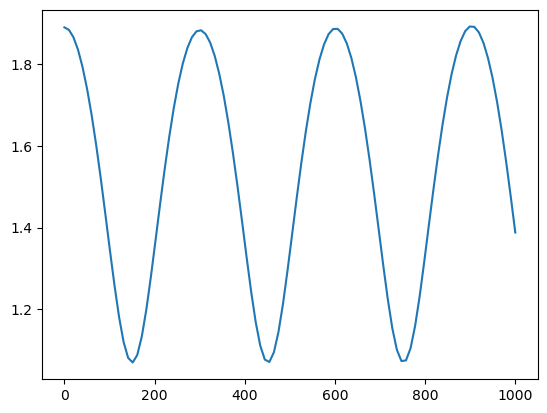

In [2]:
# Test use on hydrogen atom
import matplotlib.pyplot as plt
from pyscf import gto, dft, md


coordinates = [1.0]

mol_h2 = gto.M(
        atom = [['H',(0.0, 0.0, 0.0)], 
                ['H',(coordinates[0], 0.0, 0.0)]],
        basis = 'sto3g',
        charge = 0,
        spin = 0,
        symmetry = False,
    )

mf = QiskitNaturePySCFSolver(mol_h2) #method which computes the energy gradients and energies 
mf.xc = 'pbe,pbe'

coords = []
num_steps = 100
dt = 10 #note: dt is in in atomic units here! 1 is around 2.4*e-17s

#callback function   
def store_intermediate_results(loc):
    coords.append(loc['current_frame'].coord)
    

#Velocity Verlet Algorithm
integrator = md.NVE(mf, dt=dt, steps = num_steps, callback = store_intermediate_results,incore_anyway = True,
                    frames = []).kernel()

np_coords = np.array(coords)
abs_dist = [np.linalg.norm(np_coords[i,0,:]-np_coords[i,1,:]) for i in range(num_steps)]
times = np.linspace(0,dt*num_steps,num_steps)

plt.plot(times, abs_dist)
plt.show()